In [1]:
#un canale

In [1]:
from LibraryENGcopia import *
from tqdm.notebook import tqdm
import sklearn.preprocessing as ps
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from random import randint
from fastdtw import fastdtw
import copy
import pymc as pm
name_data = '2018-11-27T10-29-42POP 2 BL .h5'
name_data2 = '2018-11-27T12-03-02POP 2 stimulation.h5'
name_data3='2018-11-27T10-56-39MiP5 KA stimulation.h5'
name_data4='2018-11-27T11-24-28MiP3 stimulation.h5'
name_data5='2018-11-27T10-40-53POP 3 BL .h5'
complete_string='/Users/Gaia_1/Downloads/PoiProMEA-master/h5files/'+name_data
complete_string2='/Users/Gaia_1/Downloads/PoiProMEA-master/h5files/'+name_data2
complete_string3='/Users/Gaia_1/Downloads/PoiProMEA-master/h5files/'+name_data3
complete_string4='/Users/Gaia_1/Downloads/PoiProMEA-master/h5files/'+name_data4
complete_string5='/Users/Gaia_1/Downloads/PoiProMEA-master/h5files/'+name_data5

In [11]:
#data = h5py.File(complete_string,'r')
#data = h5py.File(complete_string2,'r')
#data = h5py.File(complete_string3,'r')
data = h5py.File(complete_string4,'r')
#data = h5py.File(complete_string5,'r')

data_readings = data['Data']['Recording_0']['AnalogStream']['Stream_0']['ChannelData'][()]
info = data['Data']['Recording_0']['AnalogStream']['Stream_0']['InfoChannel'][()]
info_table = pd.DataFrame(info, columns = list(info.dtype.fields.keys()))
labels = info_table['Label']
readings = pd.DataFrame(data = data_readings.transpose(), columns = labels)
fs = 10000 #Sampling Frequency
print(readings.shape)

(4212000, 60)


In [12]:
inizio=0
#len_data=810000 #192 secondi
len_data=len(readings)
prova_multi=readings.iloc[inizio:len_data, :17]
#prova=prova.drop([b'Ref'],axis=1)
prova=prova_multi[b'46']
ref=readings[b'Ref']
ref=ref[inizio:len_data]
#prova=readings.iloc[:150000, :5]
print(prova.shape,ref.shape)

(4212000,) (4212000,)


In [13]:
lowcut = 300
highcut = 3000
fs=10000
order=8
b,a=butter_bandpass(lowcut,highcut,fs,order=order)
filt_ref=filtfilt(b,a,ref)
filt_prova=filtfilt(b,a,prova)
f_prova = filt_prova - filt_ref
prova=f_prova
prova.shape
r_prova=prova.reshape(-1, 1)
scaler = StandardScaler()
s_prova = scaler.fit_transform(r_prova)
prova=s_prova
s_prova.shape

(4212000, 1)

# Spike detection

In [14]:
pos, neg=find_all_spikes(prova)

4204888it [00:00, 11804543.73it/s]                                              

positive spikes 12062 negative spikes 17937 detected spikes: 29999 firing rate:  71.22269705603038


BL: window 3000 (threshold 4 MAD) firing 18    
BL: window 300 (thresh 3), firing 89    
KA: window 3000 (thresh 3), firing 94    
KA: window 3000 (thresh 4), firing 29    
KA: window 300, (thresh 4) firing 39   
KA: window 300, (thresh 3) firing 108   

plt.figure(figsize=(30, 15))
plt.plot(prova, label='Signal Data')
plt.scatter(pos, [prova[i] for i in pos], c='red', marker='o', label='Local Maxima')
plt.scatter(neg, [prova[i] for i in neg], c='green', marker='o', label='Local Minima')
plt.xlabel('Sample Index')
plt.ylabel('Signal Value')
plt.legend()
plt.grid(True)
plt.title('Signal Data with Detected Spikes')
#plt.axis([0,3000,-5,5])
#plt.savefig('spikes1.jpg')
plt.show()

minima,maxima=RMM(prova)
print(len(maxima))
#segnale BASELINE: firing rate=70 (spikes 26148)
#segnale Stimulation: firing rate=69 (spikes 32980)
#segnale KA stimulation: firing rate=81 (spikes 47860)

minima,maxima=find_spikes(prova)
len(maxima)
#segnale BASELINE: firing rate=27 (spikes 10276)
#segnale Stimulation: firing rate=27 (spikes 13198)
#segnale KA stimulation: firing rate=32 (spikes 19178)

minima,maxima=find_spikes_with_memory(prova)
len(maxima)
#segnale BASELINE: firing rate=25 (spikes 9270)
#segnale Stimulation: firing rate=22 (spikes 10579)
#segnale KA stimulation: firing rate=8 (spikes 5054)

plt.figure(figsize=(30, 15))
plt.plot(prova, label='Signal Data')
plt.scatter(minima, [prova[i] for i in minima], c='red', marker='o', label='Local Minima')
plt.scatter(maxima, [prova[i] for i in maxima], c='green', marker='x', label='Local maxima')
plt.xlabel('Sample Index')
plt.ylabel('Signal Value')
plt.legend()
plt.grid(True)
plt.title('Signal Data with Detected Spikes')
#plt.axis([0,30000,-5,5])
#plt.savefig('spikes2.jpg')
plt.show()

# Cutouts

In [15]:
pos_cut,n_pos, neg_cut,n_neg = cut(pos,neg,prova)
savedp = copy.deepcopy(pos_cut)
savedn = copy.deepcopy(neg_cut)

0 12062 12062 0 17937 17937


In [16]:
pos_cut=mask_cuts(pos_cut)
neg_cut= mask_cuts(neg_cut)

(12062, 30)
(17937, 30)


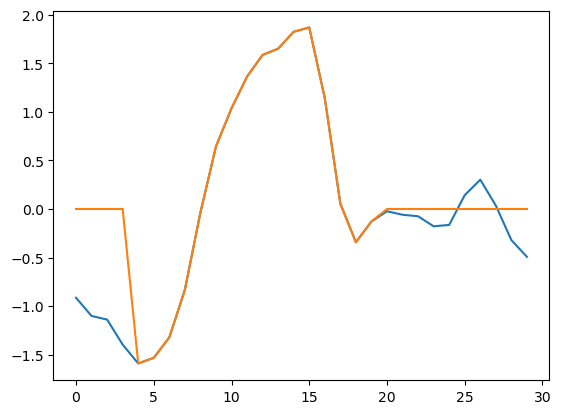

In [17]:
x=randint(1,min(len(pos_cut),len(neg_cut)))

plt.plot(savedp[x])
plt.plot(pos_cut[x])
plt.show()
#plt.plot(savedn[x])
#plt.plot(neg_cut[x])
#plt.show()

import pandas as pd
pca = PCA()
pca.fit(pos_cut)
explained_variances = pca.explained_variance_ratio_
explained_variance_df = pd.DataFrame(data={'Explained Variance': explained_variances},
                                     index=range(1, len(explained_variances) + 1))
explained_variance_df.transpose()

cumulative_explained_variance = np.cumsum(explained_variances)
cumulative_explained_variance_df = pd.DataFrame(data={'Cumulative Explained Variance': cumulative_explained_variance},
                                                index=range(1, len(cumulative_explained_variance) + 1))
cumulative_explained_variance_df.transpose()


# Clustering

Total spikes:  12062
transformed
For 3 clusters, the silhouette score is: 0.2289620539425639


/Users/Gaia_1/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


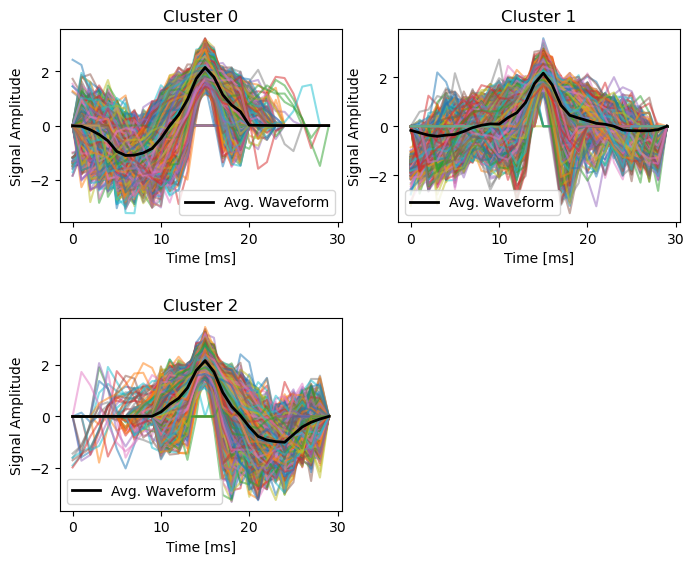

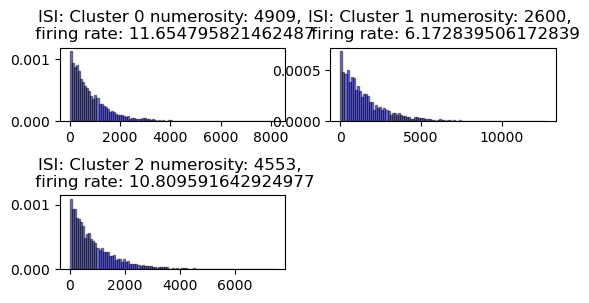

In [18]:
final_data_pos= clus(pos_cut,'fuzzy',n_pos,3,len_data)

BL (window 3000, thresh 4) (less function) fuzzy (1.8, 4, 3.99)   
BL (window 300) (less function) fuzzy (19, 18, 9)   
BL (window 300) (less function) dbscan (30, 9)   
BL (window 300) (bit less function std) fuzzy (8.9, 18.2, 17.8)   
BL (window 300) (more cut function) fuzzy (8.9, 17.7, 18.3)   
BL (window 300) (more cut function) dbscan (29, 6)   
BL (less cut function) fuzzy: (15, 8 ,15)   

KA (window 300, thresh 4) (less function) fuzzy (3.8, 4, 1.9)   
KA (window 3000, thresh 4) (less function) fuzzy (2.6, 1.2, 2.8)   
KA stimualtion 3 clusters fuzzy: (13, 6, 12)   
KA stim (window 300) (new cut function) (1.17,2.55,2.37)   


Total spikes:  17937
transformed
For 3 clusters, the silhouette score is: 0.22950297499907746


/Users/Gaia_1/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


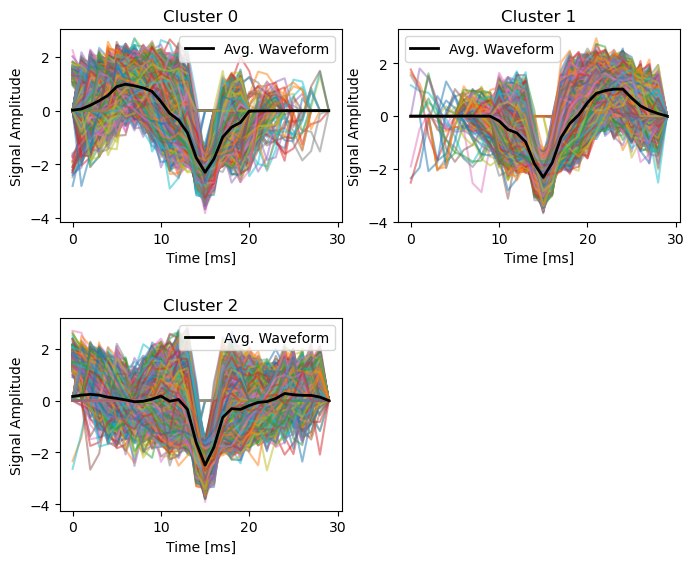

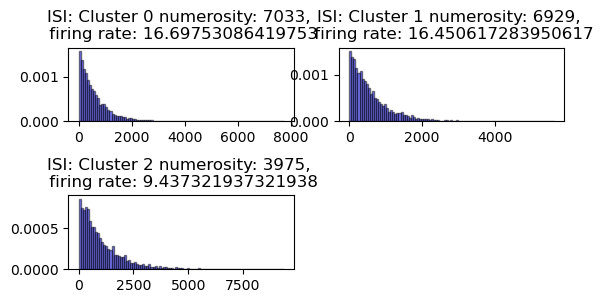

In [19]:
final_data_neg= clus(neg_cut,'fuzzy',n_neg,3,len_data)

BL (less cut function) (window 3000, thresh4) fuzzy: (3.5, 3.5, 1.6) silhouette: 0.231    
BL (less cut function) (window 300) fuzzy: (17, 15, 6) silhouette: 0.215    
BL (more cut function) (window 300) fuzzy: (15, 16, 7) silhouette: 0.218    
BL (less cut function) fuzzy: (13, 13, 6) silhouette: 0.226    

KA (less cut function) (window 300, thresh4) fuzzy: (1.9, 1.12, 1.9) silhouette: 0.229   
KA (less cut function) (window 3000, thresh4) fuzzy: (1.4, 0.89, 1.4) silhouette: 0.223    
KA stimulation 3 clusters fuzzy: (3.9, 3.7, 2) silhouette: 0.214    
KA stimulation (more cut function) (window 3000) fuzzy: (2, 3.9, 3.7) silhouette: 0.214    
KA stimulation (more cut function) (window 300) fuzzy (4.5, 4.4, 2.2) silhouette: 0.204    
KA stimulation (more cut function) (window 300) dbscan (10.8,10.8)    

In [13]:
neurons = []
for neuron in final_data_pos:
    neurons.append(neuron)
for neuron in final_data_neg:
    neurons.append(neuron)
neurons

[array([    196,     830,     947, ..., 5873475, 5873964, 5874474]),
 array([    951,    1329,    1815, ..., 5872909, 5873337, 5874183]),
 array([   2630,    5447,    6310, ..., 5873557, 5873649, 5874558]),
 array([    840,    1092,    1825, ..., 5871955, 5872336, 5873586]),
 array([    876,    4213,    6658, ..., 5867216, 5872554, 5873099])]

In [54]:
data_healthy=neurons[2]
ISI_healthy = np.diff(data_healthy)/10000

## Point Process

In [55]:
ISI_data=ISI_healthy
with pm.Model() as model:
    ##### WALD DISTRIBUTION (INVERSE GAUSSIAN)
    mu1 = pm.Uniform('mu1',lower=0.01,upper=0.1)
    lam1 = pm.Uniform('lam1',lower=0.01,upper=0.04)
    obs1 = pm.Wald.dist(mu=mu1,lam=lam1)


    mu2 = pm.Uniform('mu2',lower=0,upper=0.2)
    sigma2 = pm.Uniform('sigma2',lower=0.0001,upper=0.5)
    obs2 = pm.TruncatedNormal.dist(mu=mu2, sigma=sigma2, lower=0.0)

    mu3 = pm.Uniform('mu3',lower=0.1,upper=0.6)
    sigma3 = pm.Uniform('sigma3',lower=0.0001,upper=0.5)
    obs3 = pm.TruncatedNormal.dist(mu=mu3, sigma=sigma3, lower=0.0)


    w = pm.Dirichlet('w', a=np.array([1., .4, .4]))
    #w = pm.Dirichlet('w', a=np.array([1., .4]))

    like = pm.Mixture('like', w=w, comp_dists = [obs1, obs2, obs3], observed=ISI_data)
    #like = pm.Mixture('like', w=w, comp_dists = [obs1, obs2], observed=ISI_data)
    map_estimate = pm.find_MAP(model=model)
    
    step = pm.NUTS(target_accept=0.9)
    trace = pm.sample(step=step,draws=1000,chains=1,tune=1000,cores=4)


Sequential sampling (1 chains in 1 job)
NUTS: [mu1, lam1, mu2, sigma2, mu3, sigma3, w]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 202 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


Sampling: [like]


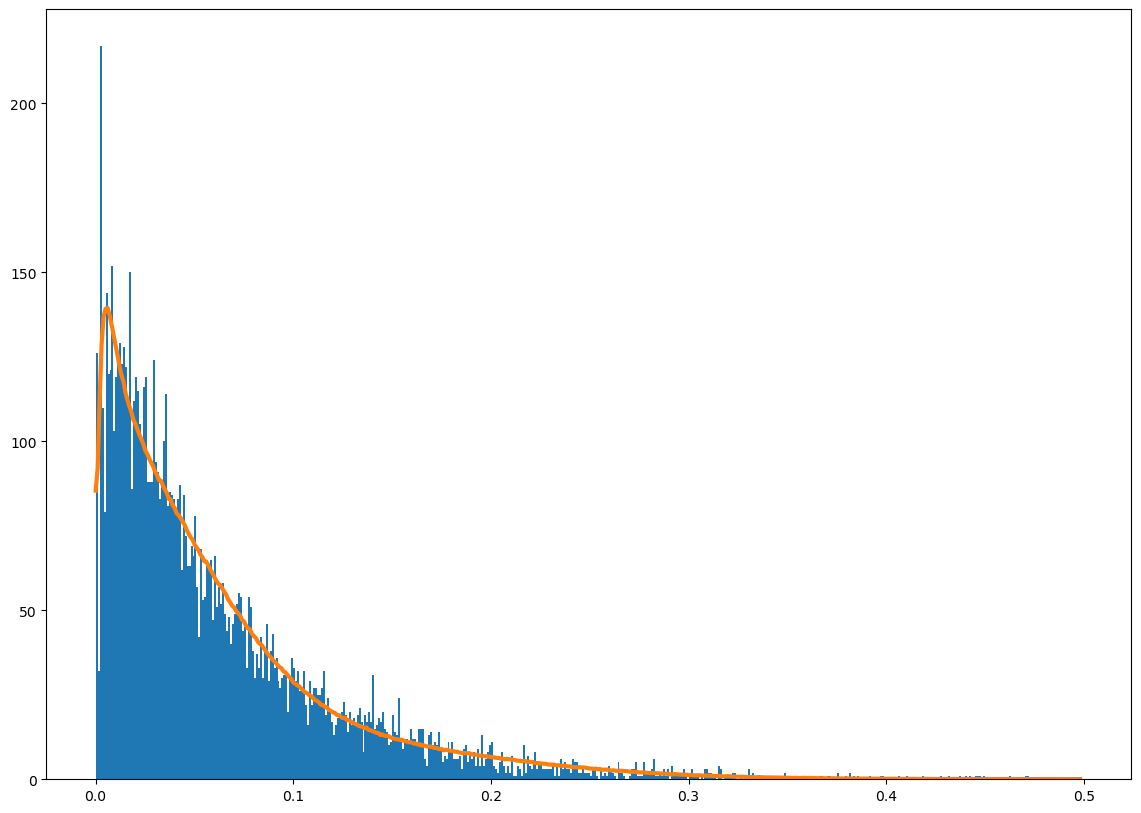

In [56]:
with model:
    ppc_trace = pm.sample_posterior_predictive(trace,model=model)

bins = np.arange(0, .5, 1e-3) 
plt.figure (figsize=(14,10))

hist = np.histogram(ppc_trace['posterior_predictive']['like'].values,bins=bins)
#plt.axis([0,0.3,0,160])
a= plt.hist(ISI_healthy,bins)
plt.plot(hist[1][:-1],hist[0]/1000,linewidth=3);

In [57]:
lista_samples=[]
for i in list(ppc_trace['posterior_predictive']['like'].values):
    lista_samples.extend(i)

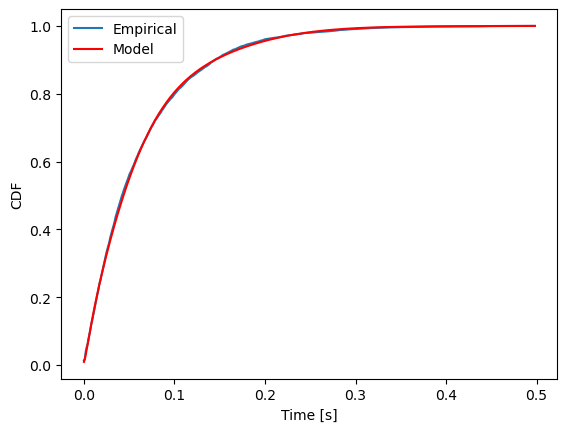

In [58]:
counts, _ = np.histogram(ISI_healthy, bins) 
prob_emp = counts / np.sum(counts)
counts, _ = np.histogram(lista_samples, bins) 
prob_model = counts / np.sum(counts)

Femp = np.cumsum(prob_emp)           
Fmodel = np.cumsum(prob_model)          
plt.figure()
plt.plot(bins[:-1], Femp)                
plt.plot(bins[:-1], Fmodel, 'r')       
#plt.xlim([0, 0.2])                  
plt.xlabel('Time [s]')
plt.ylabel('CDF')
plt.legend(['Empirical','Model'])
plt.show()

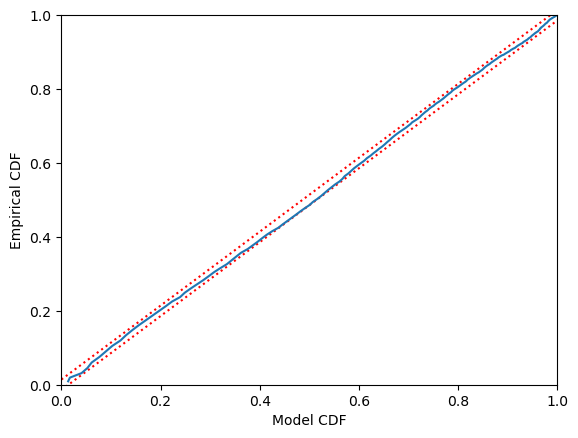

In [59]:
plt.figure()
Nlow = len(ISI_healthy)  
# Plot the confidence bounds
plt.plot([0, 1], [x + 1.36 / np.sqrt(Nlow) for x in [0, 1]], 'r:')
plt.plot([0, 1], [x - 1.36 / np.sqrt(Nlow) for x in [0, 1]], 'r:')
plt.plot(Femp, Fmodel)
plt.axis([0, 1, 0, 1])         
plt.xlabel('Model CDF')
plt.ylabel('Empirical CDF')
plt.show()

In [60]:
map_estimate = pm.find_MAP(model=model)
del map_estimate['w_simplex__']
del map_estimate['mu1_interval__']
del map_estimate['lam1_interval__']
del map_estimate['mu2_interval__']
del map_estimate['sigma2_interval__']
del map_estimate['mu3_interval__']
del map_estimate['sigma3_interval__']

map_estimate['w1'] = map_estimate['w'][0]
map_estimate['w2'] = map_estimate['w'][1]
map_estimate['w3'] = map_estimate['w'][2]

del map_estimate['w']


map_estimate

{'mu1': array(0.0585939),
 'lam1': array(0.03423544),
 'mu2': array(5.7932706e-111),
 'sigma2': array(0.08184228),
 'mu3': array(0.1),
 'sigma3': array(0.00010089),
 'w1': 0.34212080707303694,
 'w2': 0.6578791929269631,
 'w3': 1.9524243774789846e-119}